# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [1]:
from kan import *

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

Train KAN (grid=3)

In [2]:
model.train(dataset, opt="LBFGS", steps=20);

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]/home/rd/anaconda3/envs/pykan-env/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
train loss: 1.43e-02 | test loss: 1.50e-02 | reg: 2.97e+00 : 100%|██| 20/20 [00:03<00:00,  6.04it/s]


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Train KAN (grid=10)

In [4]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 3.68e-04 | test loss: 3.97e-04 | reg: 2.96e+00 : 100%|██| 20/20 [00:03<00:00,  5.14it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [5]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 6.42e-03 | test loss: 6.55e-03 | reg: 2.80e+00 : 100%|██| 50/50 [00:09<00:00,  5.38it/s]
train loss: 2.92e-04 | test loss: 3.28e-04 | reg: 2.82e+00 : 100%|██| 50/50 [00:03<00:00, 14.84it/s]
train loss: 2.11e-05 | test loss: 2.23e-05 | reg: 2.82e+00 : 100%|██| 50/50 [00:04<00:00, 11.29it/s]
train loss: 4.57e-06 | test loss: 9.14e-06 | reg: 2.82e+00 : 100%|██| 50/50 [00:04<00:00, 10.05it/s]
train loss: 2.65e-06 | test loss: 8.64e-06 | reg: 2.82e+00 : 100%|██| 50/50 [00:03<00:00, 15.53it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

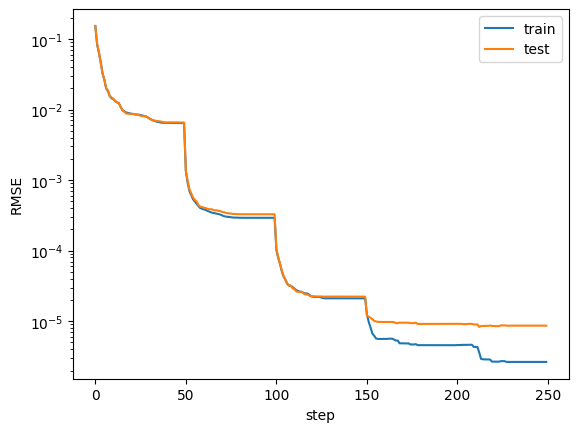

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

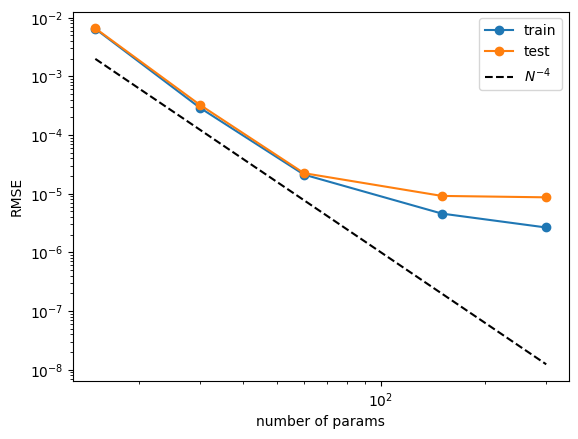

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')